In [1]:
import keras
import numpy as np
import os
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
import matplotlib.pyplot as plt
import datetime
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from keras import models,layers
from keras.applications import VGG16

Using TensorFlow backend.


In [2]:
#load the Fashion MNIST data
fashion_mnist = keras.datasets.fashion_mnist
(train_images,train_labels),(test_images,test_labels) = fashion_mnist.load_data()


4423680/4422102 [==============================] - 0s 0us/step


Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


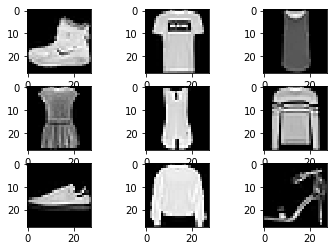

In [3]:
# summarize loaded dataset
print('Train: X=%s, y=%s' % (train_images.shape, train_labels.shape))
print('Test: X=%s, y=%s' % (test_images.shape, test_labels.shape))
# plot first few images
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(train_images[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

In [0]:
# Deviding pixel values by 255 to get them between 0-1 for easier training
train_images = train_images.reshape((60000,28,28,1))
train_images = train_images/255.0
test_images = test_images.reshape((10000,28,28,1))
test_images = test_images/255.0

In [0]:
#lets create validation data from the training dataset
val_train_images  = train_images[:10000]
val_train_labels = train_labels[:10000]

In [0]:
#Remaining training data
partial_train_images = train_images[10000:]
partial_train_labels = train_labels[10000:]

In [0]:
# Save classnames for later use
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [0]:
#define a small CNN network
def create_model():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3,3), padding = 'same', activation = 'relu', kernel_initializer='he_uniform', input_shape=(28,28,1)))
  model.add(layers.Conv2D(32, (3,3), padding = 'same', activation = 'relu', kernel_initializer='he_uniform'))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu',kernel_initializer='he_uniform'))
  model.add(layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu',kernel_initializer='he_uniform'))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Dropout(0.5))
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation = 'relu'))
  model.add(layers.Dropout(0.25))
  model.add(layers.Dense(10, activation = 'softmax'))
  return model



In [9]:
model = create_model()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)         

In [11]:
# compile the model defined above
from keras.optimizers import Adam
opt = Adam(lr=0.001)
model.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [0]:
#Add callbacks for more efficient training of the models
#log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
stop = EarlyStopping(monitor = 'val_loss', patience = 10,verbose=1)
checkpoint = ModelCheckpoint(filepath='fashion_mnist_weights.h5',monitor='val_loss',verbose = 1, save_best_only = True)
reduce = ReduceLROnPlateau(monitor='val_loss',factor = 0.1, patience = 3, verbose = 1)
#tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1, batch_size=128, write_graph = True, write_grads = True, write_images = True)



In [13]:
#train the model on the partial training data and save results in history object
history = model.fit(partial_train_images,partial_train_labels, epochs = 100, batch_size = 128, validation_data = (val_train_images,val_train_labels), callbacks = [stop,checkpoint,reduce])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 50000 samples, validate on 10000 samples
Epoch 1/100





50000/50000 [==============================] - 11s 219us/step - loss: 0.6910 - acc: 0.7565 - val_loss: 0.3523 - val_acc: 0.8721

Epoch 00001: val_loss improved from inf to 0.35232, saving model to fashion_mnist_weights.h5
Epoch 2/100
50000/50000 [==============================] - 4s 75us/step - loss: 0.3929 - acc: 0.8567 - val_loss: 0.3016 - val_acc: 0.8906

Epoch 00002: val_loss improved from 0.35232 to 0.30161, saving model to fashion_mnist_weights.h5
Epoch 3/100
50000/50000 [==============================] - 4s 75us/step - loss: 0.3394 - acc: 0.8733 - val_loss: 0.3104 - val_acc: 0.8785

Epoch 00003: val_loss did not improve from 0.30161
Epoch 4/100
50000/50000 [==============================] - 4s 74us/step - loss: 0.3072 - acc: 0.8846 - val_loss: 0.2375 - val_acc: 0.9111

Epoch 00004: val_loss improved from 0.30161 to 0.

In [0]:
#save model weights in a h5 file
model.save('fashion_mnist_weights.h5')
#save model in a json file
model_json = model.to_json()
with open('fashion_mnist_model.json',"w") as json_file:
    json_file.write(model_json)

In [0]:
from google.colab import files
files.download("fashion_mnist_weights.h5")
files.download("fashion_mnist_model.json") 

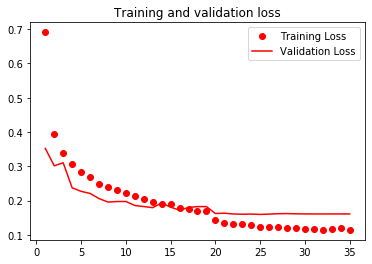

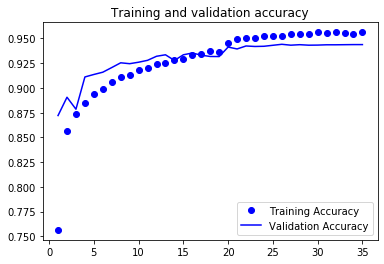

In [15]:
#plot loss and validation curves during Training
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs,loss,'ro',label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.plot(epochs,acc,'bo',label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [16]:
test_loss,test_accuracy  = model.evaluate(test_images,test_labels)

10000/10000 [==============================] - 1s 64us/step


In [17]:
print ("Test accuracy :",test_accuracy)

Test accuracy : 0.9369
